In [1]:
# 1.0 - TensorFlow model
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from random import shuffle
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.models import Model
from keras.utils import to_categorical
import keras.backend as K
from keras import optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

#from cnn_utils import *

%matplotlib inline
np.random.seed(1)

Using TensorFlow backend.


In [2]:
# Mount data from google drive    
# Dataset to be imported below:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#Load Datasets
#X_data = h5py.File('/content/gdrive/Team Drives/CS 230 Project/Cereal pics/X_data.h5', 'r')
#Y_data = h5py.File('/content/gdrive/Team Drives/CS 230 Project/Cereal pics/Y_data.h5', 'r')
  
X_data = h5py.File('X_data.h5', 'r')
Y_data = h5py.File('Y_data.h5', 'r')
  
#Specify Split ratios
Train_percent = 0.7
Dev_percent = 0.15
Test_percent = 0.15

#Get shapes of data:
m = len(X_data)
h_X,w_X,c_X = np.shape(X_data['X1'])

#Get indices of train/dev/test split
temp_list = list(range(m))
shuffle(temp_list)
Train_list = temp_list[0:int(Train_percent*m)]
Dev_list = temp_list[int(Train_percent*m):int(Train_percent*m)+int(Dev_percent*m)]
Test_list = temp_list[int(Train_percent*m)+int(Dev_percent*m):
                      int(Train_percent*m)+int(Dev_percent*m)+int(Test_percent*m)]

# Create np arrays for train/dev/test set
X_train_orig = np.empty((len(Train_list),h_X,w_X,c_X))
Y_train_orig = np.empty(len(Train_list))
X_dev_orig = np.empty((len(Dev_list),h_X,w_X,c_X))
Y_dev_orig = np.empty(len(Dev_list))
X_test_orig = np.empty((len(Test_list),h_X,w_X,c_X))
Y_test_orig = np.empty(len(Test_list))

#Copy data from dataset onto the np arrays
for ind,item in enumerate(Train_list):
    X_train_orig[ind]=X_data['X'+str(item)][:]
    Y_train_orig[ind]=Y_data['y'+str(item)][:]
for ind,item in enumerate(Dev_list):
    X_dev_orig[ind]=X_data['X'+str(item)][:]
    Y_dev_orig[ind]=Y_data['y'+str(item)][:]
for ind,item in enumerate(Test_list):
    X_test_orig[ind]=X_data['X'+str(item)][:]
    Y_test_orig[ind]=Y_data['y'+str(item)][:]

print("Done building dataset")

Done building dataset


In [4]:
# To get started, let's examine the shapes of your data.
X_train = X_train_orig/255.
X_dev = X_dev_orig/255.
X_test = X_test_orig/255.
Y_train = to_categorical(Y_train_orig, num_classes=165, dtype='int32')
Y_dev = to_categorical(Y_dev_orig, num_classes=165, dtype='int32')
Y_test = to_categorical(Y_test_orig, num_classes=165, dtype='int32')
X_train_orig, X_dev_orig, X_test_orig = None, None, None
Y_train_orig, Y_dev_orig, Y_test_orig = None, None, None
del X_data
del Y_data
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of dev examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(Y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 6244
number of dev examples = 1338
number of test examples = 1338
X_train shape: (6244, 256, 256, 3)
Y_train shape: (6244, 165)
X_dev shape: (1338, 256, 256, 3)
Y_dev shape: (1338, 165)
X_test shape: (1338, 256, 256, 3)
Y_test shape: (1338, 165)


In [5]:
# Define the Model and Network Architecture

def BaselineModel(input_shape):
    """

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """

    ### START CODE HERE ###
    # Feel free to use the suggested outline in the text above to get started, and run through the whole
    # exercise (including the later portions of this notebook) once. The come back also try out other
    # network architectures as well. 


    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!

    X_input = Input(input_shape)
    
    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    
    X = Dropout(0.5)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    
    X = Dropout(0.5)(X)
    
    #FLATTEN
    X = Flatten()(X)
    X = Dense(165, activation='softmax', name='fc')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Baseline')

    return model

In [6]:
BaseModel = BaselineModel(X_train.shape[1:])

In [7]:
adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-10, decay=0.0, amsgrad=False)
BaseModel.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [8]:
history = BaseModel.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs = 25, batch_size = 32)

Train on 6244 samples, validate on 1338 samples
Epoch 1/25
6244/6244 [==============================] - 44s 7ms/step - loss: 4.5826 - acc: 0.1742 - val_loss: 1.7502 - val_acc: 0.8079
Epoch 2/25
6244/6244 [==============================] - 39s 6ms/step - loss: 1.3772 - acc: 0.6417 - val_loss: 0.6468 - val_acc: 0.9425
Epoch 3/25
6244/6244 [==============================] - 39s 6ms/step - loss: 0.5616 - acc: 0.8507 - val_loss: 0.3498 - val_acc: 0.9776
Epoch 4/25
6244/6244 [==============================] - 39s 6ms/step - loss: 0.3198 - acc: 0.9089 - val_loss: 0.2295 - val_acc: 0.9865
Epoch 5/25
6244/6244 [==============================] - 39s 6ms/step - loss: 0.1774 - acc: 0.9536 - val_loss: 0.1666 - val_acc: 0.9918
Epoch 6/25
6244/6244 [==============================] - 39s 6ms/step - loss: 0.1400 - acc: 0.9614 - val_loss: 0.1421 - val_acc: 0.9888
Epoch 7/25
6244/6244 [==============================] - 39s 6ms/step - loss: 0.1122 - acc: 0.9725 - val_loss: 0.1015 - val_acc: 0.9985
Epoch 8

In [9]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


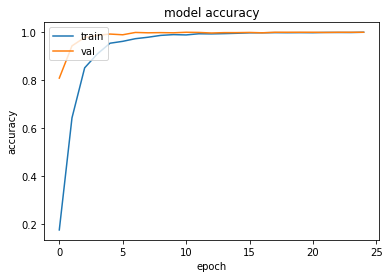

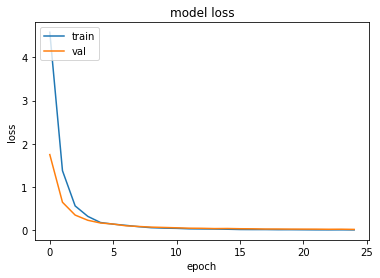

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
BaseModel.evaluate(X_test,Y_test)

1338/1338 [==============================] - 3s 2ms/step


[0.009273659142767189, 1.0]

In [12]:
BaseModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 250, 250, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 250, 250, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 58, 128)       102528    
__________

In [13]:
y_pred = BaseModel.predict(X_test)

In [14]:
np.argmax(y_pred[0])

10

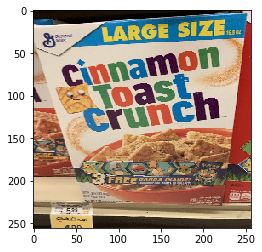

In [15]:
plt.imshow(X_test[0])

In [22]:
from sklearn.metrics import roc_auc_score
print(str.format('{0:.16f}',roc_auc_score(Y_test, y_pred)))

1.0000000000000000
